# Topics in Applied Optimization (IIIT, Hyderabad, India)
# Jupyter Notebook Assignment-1
### Instructor: Dr. Pawan Kumar (IIIT, H) (https://faculty.iiit.ac.in/~pawan.kumar/)
If you are not familiar with Jupyter notebook, before proceeding further, please go and watch this video:

https://www.youtube.com/watch?v=HW29067qVWk

## Regarding assignments
### Deadline: 13 October 2023
- all the assignment is to be done in this notbook itself
- any proof etc can be done on paper, and image is to be inserted in this notebook
- save this notebook with your roll number and upload it in moodle
- basic familiarity with python is required, brush up if necessary
- you are not allowed to use any existing library for gradient methods; this defeats the purpose of this assignment
- sample output is in the zip file of assignment
- if there are any doubt, then raise it in course moodle site, it may help others
- if you find typo, raise this issue in moodle promptly!
- please avoid copying from others, there may be oral exam to test your knowledge

# Implementation of Recommender System Using Latent Factor Model in Python

Please refer to the class slides for more detail. Also, for full detail, please refer the following main reference:

**[1] Y. Koren, R. Bell, and C. Volinsky, Matrix Factorization Techniques for Recommender Systems, Computer Archive, Volume 42, Issue 8, 2009**

We first load the necessary libraries:
1. matplotlib: needed for plotting figures and
2. numpy needed for doing math

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Now we write the main functions

We write everything inside a class LF, which stands for latent factor. We need the following functions:
1. main
2. train
3. mse
4. sgd
5. predict
6. full_matrix

# Short Tutorial on Recommender Systems
Please see lecture slides for more detail.

## Latent Factor Model
In a recommender systems, we are given an incomplete ratings matrix say R. The $(i,j)$ entry of this matrix is denoted by $r_{ij}.$
- We believe that there are dependencies in the matrix, i.e., the matrix is low rank, hence it can be written as a product of low rank matrices.
- Even if the matrix is not strictly low rank, we believe that certain features are more important than others. In other words, if the ratings matrix were full, then after doing SVD, we get
$$R = U S V^T$$
some of the singular values were very small, hence the matrix can be approximated well with truncated SVD. Let us consider the first $k$ largest singular vectors, then the truncated SVD is
$$R \approx U_k S_k V_k.$$
- See IPSC notes for more detail on how to compute SVD or truncated SVD
- For a recomendation problem, for example, movie recomendation or news recommendation or product recommendation, etc, we believe that certain latent features are most important and play a major role in ratings.
- For movie recommendation, for example, latent factors could be comedy, adventure, horror, etc. These features are called latent, because the given data, which is ratings matrix does not explicitely tells about these.
- For recommendation systems, we cannot do SVD, because the matrix $R$ is incomplete! Obviously, we cant treat the missing entries to be zero! Hence, instead of doing SVD, we will consider an error function that consider only the ratings that are given. Let us assume that the ratings matrix can be modelled as a latent factors, i.e., suppose that $$R = PQ, \quad P \in \mathbb{R}^{n \times k}, Q \in \mathbb{R}^{k \times n},$$ then the given rating $$r_{ij} = p_{i*}q_{*j},$$ where $p_{i*}$ denotes the $i$th row of $P,$ and $q_{*j}$ denotes the $j$th column of $Q.$


## Optimization Model
- As mentioned above, we cannot directly do SVD, however, we can indeed create a **loss function** as follows:
$$\mathcal{L}(p_{1*}, p_{2*}, \dots p_{n*}, q_{*1}, q_{*2}, \dots, q_{*n}) = \sum_{(i,j) \in K} (r_{ij} - p_{i*}q_{*j}).$$
- Note above that we see loss function as a function the variables $p_{1*}, p_{2*}, \dots, p_{*n},$ which are row vectors of $P,$ and as the column vectors of $Q,$ which are $q_{*1}, q_{*2}, \dots, q_{*n}.$ This allows us to **vectorize**. Why vectorize?
- In machine learning the weights and their combinations with the given data creates a model. In this case, the model is $PQ.$ Since the $k,$ is a hyperparameter, it is likely that one may choose $P$ and $Q$ to have too many columns, i.e., too many weights are used, this will lead to a large model, and hence leading to **overfitting**.
If you are not familiar with overfitting, then pause here, and see the video here:

https://www.youtube.com/watch?v=u73PU6Qwl1I

    - What did you learn from video?
    - What is termed as model?
    - What is the meaning of model being large?
    - What is the difference between linear and logistic regression?
    - What is underfitting?
    - What is a bias?
    - How do you characterize bias and variance using terms overfitting or underfitting?

- A well known way to avoid overfitting is to do regularizations, by penalizing **large model** size. Let us modify our loss function as follows:
$$\mathcal{L}(\cdot) = \sum_{(i,j) \in K} (r_{ij} - p_{i*}q_{*j})^2 + \gamma/2 (\| P \|_F^2 + \| Q \|_F^2)$$
    - We have added the term $\gamma/2(\| P \|_F^2 + \| Q \|_F^2).$ It is called **regularization term**
    - The parameter $\gamma$ is called the **regularization parameter**
    - High $\gamma$ would mean that we don't want big model size; this may help prevent overfitting
- Let $e_{ij}$ denote the error corresponding to each $(ij)$ term,
$$e_{ij} = r_{ij} - \sum_{s=1}^k p_{is}q_{sj}$$
then let us define the new error term $\tilde{e}$
$$\tilde{e}_{ij} = e_{ij}^2 + \gamma/2 (\|P\|_F^2 + \| Q \|_F^2),$$
that is,
$$\tilde{e}_{ij} = (r_{ij} - \sum_{s=1}^k p_{is}q_{sj} )^2 + \gamma/2 (\|P\|_F^2 + \| Q \|_F^2)$$
- Note that $$\mathcal{L}(\cdot) = \sum_{(i,j) \in \mathcal{K}} \tilde{e}_{ij},$$
where $\mathcal{K}$ is the set of all indices for which ratings $r_{ij}$ are available.


## Gradient Method Versus Stochastic Gradient Methods
Following notes are taken from
https://en.wikipedia.org/wiki/Stochastic_gradient_descent

For large dataset, $k$ and $n$ tend to be large, and computing gradient fully becomes too demanding. In machine learning or statistical estimation, we are usually required to find minimum of the loss functions of the form
$$Q(w) = 1/n \sum_{j=1}^n Q_j (w)$$
That is loss function as "additive" decomposition. In other words, the loss function is a sum of the loss function where the sum is over the data samples. If $n$ is large, then computing full gradient is computationally demanding. However, if we indeed decide to run the gradient method. Then we recall the following steps:
1. Take initial random weight (possibly random and normally distributed between 0 and 1): $w^0$
2. $w^{i+1} = w^i - \alpha \nabla Q(w^i), \quad i=0, \dots$

Here the gradient $\nabla Q$ is the full gradient in the sense that
\begin{align}
\nabla Q(w) = \sum_{i=1}^n \nabla_{w}Q_i(w). \label{grad} \tag{1}
\end{align}

Here
\begin{align}
\nabla_w Q_i (w) = \begin{bmatrix}
\dfrac{\partial Q_i (w)}{\partial w_1} \\
\dfrac{\partial Q_i (w)}{\partial w_1} \\
\vdots \\
\dfrac{\partial Q_i (w)}{\partial w_n} \\
\end{bmatrix}  \label{grad2} \tag{2}
\end{align}

### Stochastic gradient  descent method
Stochastic gradient merthod, in short, SGD is a method (not necessarily descent due to stochasticity, but in expectation is usually is a descent), where the gradient is computed partially. For example, instead of summing for all $i=1...n,$ we can take a random sample, say $j_1,$ and do the update only for this sample as follows:
$$\nabla Q(w) = \nabla_{w}Q_{j_1}(w),$$
that is we have picked just one of the term i.e., $j_1$th term from \eqref{grad}.
Then the SGD update is:
$$w^{i+1} = w^i - \alpha \nabla Q_{j_1}(w^i), \quad i=0, \dots$$
Note that we could have taken few more terms in the sum, and would have updated for a batch. This is called, batched stochastic gradient descent.
It sounds incorrect, isnt it? Why such method may converge? With some basic assumption on the loss function, we can prove some convergence in expectance. More on convergence theory in class!

$\color{red}{\text{Question-0:}}$ Compute the full gradient of the loss function for recommendation system

$\color{red}{\text{Answer:}}$

The loss function for recommendation systems is often represented as the sum of squared errors (mean squared error or MSE).

The loss function is
\begin{equation}
MSE(\Theta) = \frac{1}{N} \sum_{(u,i)} (r_{ui} - \hat{y}_{ui})^2
\end{equation}

The gradient of the loss function is given by:
\begin{equation}
\nabla MSE(\Theta) = \frac{1}{N} \sum_{(u,i)} 2(r_{ui} - \hat{y}_{ui}) \nabla \hat{y}_{ui}
\end{equation}

∇MSE(Θ) is the gradient of the mean squared error loss function.

N is the total number of ratings or observations

$r_{ui}$ is the actual user-item rating or observation.


$\hat{y}_{ui}$ is the predicted rating by the recommendation system for user u and item i

$\nabla \hat{y}_{ui}$ is the gradient of the predicted rating



In the following, we derive a stochastic gradient for the loss function for recommender loss.

## Gradient Method for Optimization Problem
- We want to use gradient method to minimize the error. An update in gradient method is given as follows
$$w^{i+1} = w^i - \nabla \mathcal{L}(w^i)$$
- To use gradient method, we need to compute gradient. If we see $\mathcal{L}$ as a function of $p_{ik}'$s and $q_{ki}'$s, then
$$\dfrac{\partial \mathcal{L}}{\partial p_{is}} = 2e_{is} \dfrac{\partial e_{is}}{\partial p_{is}} + \gamma p_{is} = -2e_{is} q_{sj} + \gamma p_{is}$$
Similarly,
$$\dfrac{\partial \mathcal{L}}{\partial q_{sj}} = 2e_{sj} \dfrac{\partial e_{sj}}{\partial q_{sj}}+\gamma q_{sj} = -2e_{sj}p_{js} + \gamma q_{sj},$$
- The gradient vector $\nabla \mathcal{L}$ is given by
$$\nabla \mathcal{L} = \left(\dfrac{\partial \mathcal{L}}{\partial p_{11}}, \dots, \dfrac{\partial \mathcal{L}}{\partial p_{nk}}, \dfrac{\partial \mathcal{L}}{\partial q_{11}}, \dots, \dfrac{\partial \mathcal{L}}{\partial p_{kn}} \right)$$
- The weights $p_{is}$ can be updated as
$$p_{is} = p_{is} + \alpha (2e_{ij} q_{sj} - \gamma p_{is}) $$
- The weights $p_{sj}$ can be updated as
$$q_{sj} = q_{sj} + \alpha (2e_{ij} p_{js} - \gamma q_{sj}) $$
- We can vectorize $s.$ Finally, the vectorized form of the update looks like:
$$(p_{i+1*}, q_{*j+1})^T = (p_{i*}, q_{*j})^T + \alpha ((2e_{ij} q_{*j} - \gamma p_{i*}), (2e_{ij} p_{j*} - \gamma q_{*j}))^T  $$
- The error at $(p_{i*}, q_{*j})^T$ nedded above can be computed by $$e_{ij} =  r_{ij} - \text{prediction at}~ (i,j) $$
Here prediction at $(i,j)$ can be computed by making a call to predict() function below.

$\color{red}{\text{Question-1:}}$ Why the error is computed this way?

$\color{red}{\text{Answer:}}$

The primary objective of gradient descent is to find the optimal values of the parameters (e.g., weights in machine learning models) that minimize a certain cost or error function.

Gradient descent leverages the differential information provided by the gradient of the error function with respect to the parameters. The gradient indicates the direction of the steepest increase in error. By moving in the opposite direction (negative gradient), we aim to decrease the error iteratively.

Most loss functions (such as MSE) are usually convex and differentiable.These properties help optimize the cost function as the gradient descent ensures that there is a unique minimum, and the gradient exists everywhere.

The error function quantifies how far off our model's predictions are from the true values or labels. By computing the error and its gradient, we essentially quantify the mistakes made by the model. Gradient descent then uses this information to iteratively adjust the parameters to reduce these mistakes and improve model performance.

Thus, computation of error in gradient descent helps improve the performance of the model.

$\color{red}{\text{Question-2:}}$ Are the updates for $p_{i*}$ and $q_{*j}$ stochastic? Justify.

$\color{red}{\text{Answer:}}$ Yes, the updates for  $p_{i*}$ and $q_{*j}$  are stochastic. This is because stochastic randomly picks one data point from the whole data set at each iteration to reduce the computations enormously.
The loss function is computed using only one randomly chosen data point (a single rating) at a time, and the model parameters are updated based on the gradient of the loss function with respect to the parameters for that specific data point. SGD is a more computationally efficient as compared to GD.

In GD the loss function is computed using the entire training dataset (all available ratings), and the model parameters are updated based on the average gradient (or derivative) of the loss function with respect to the parameters. The update step considers the entire dataset, and this can be computationally expensive for large datasets.

# Adding Bias
It is often observed in practice that adding a bias term helps. Let us add the bias term $b$ to the prediction function. The bias term is computed as the mean of the ratings matrix. See the predict function below to see how bias is added.

$\color{red}{\text{Question-2b:}}$ Read the main reference paper and justify why bias is added. Note in this notebook we add global bias. Which other bias term was suggested in the paper?

$\color{red}{\text{Answer:}}$

Bias is added in the recommender system to account for the effects associated with either users or items that are independent of any interactions. These effects, known as biases or intercepts, contribute to the observed variation in rating values. For example, some users tend to give higher ratings than others, and some items receive higher ratings than others. By incorporating bias, the system can explain the portion of rating values that can be attributed to these user and item effects, allowing the true interaction portion of the data to be subjected to factor modeling.

In addition to the global bias term, the paper suggests the inclusion of user bias and item bias as other bias terms. These bias terms are important for accurately modeling the observed signal in collaborative filtering data. The user bias captures the tendency of certain users to give higher or lower ratings, while the item bias captures the tendency of certain items to receive higher or lower ratings. By including these bias terms, the system can better explain the variation in rating values due to user and item effects independent of any interactions.

In [ ]:
class LF():

    def __init__(self, R, K, alpha, gamma, iterations):
        """
        Parameters:
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - gamma (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.gamma = gamma
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Compute the global bias
        # For Question-6, you may want to initialize additional bias terms here
        self.b = np.mean(self.R[np.where(self.R != 0)])
        #self.b_i = TODO
        #self.b_u = TODO

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("SGD Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        MSE: Compute Mean Square Error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        SGD: Stochastic Graident Descent
        """
        for i, j, r in self.samples:
            # Compute prediction and error
            prediction =  lf.predict(i,j)


            e = r - prediction

            # Keep a copy of row of P. It will be needed for update
            # P_i = self.P[i, :][:]

            # Vectorized update for P[i, :] and Q[j, :]
            delta_p = 2 * e * self.Q[j, :] - self.gamma * self.P[i, :]
            delta_q = 2 * e * self.P[i, :] - self.gamma * self.Q[j, :]


            # Update user and item latent feature matrices
            self.P[i, :] +=  self.alpha * delta_p
            self.Q[j, :] +=  self.alpha * delta_q


    def gd(self):
        """
        GD: Graident Descent
        Replace self.sample below to full batch for gradient descent
        Feel free to remove everything, and implement from scratch
        """
        # for i, j, r in TODO:
        #     # Compute prediction and error
        #     prediction = TODO
        #     e = TODO

        #     # Create copy of row of P since we need to update it but use older values for update on Q
        #     P_i = self.P[i, :][:]

        #     # Update user and item latent feature matrices
        #     self.P[i, :] += TODO
        #     self.Q[j, :] += TODO

        for i in range(self.num_users):
          for j in range(self.num_items):
            if self.R[i, j] > 0:
                prediction =  lf.predict(i,j)

                # Compute prediction and error
                self.P[i, :].dot(self.Q[j, :].T)
                e += self.R[i, j] - prediction


        for i in range(self.num_users):
            P_i = self.P[i,:][:]
            self.P[i, :] += self.alpha * (2 * e * Q_j - self.gamma * P_i)



        for j in range(self.num_items):
            Q_j = self.Q[j, :][:]
            self.Q[j, :] += self.alpha * (2 * e * P_i - self.gamma * Q_j)


    def predict(self, i, j):
        """
        Prediction: Predicted the rating of user i and item j
        """
        prediction = self.b + self.P[i, :].dot(self.Q[j, :].T)

        return prediction

    def full_matrix(self):
        """
        The rating matrix using the biases P and Q
        """
        return lf.b + lf.P.dot(lf.Q.T)


In [ ]:
R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

lf = LF(R, K=2, alpha=0.1, gamma=0.01, iterations=100)
training_process = lf.train()
print()
print("P x Q:")
print(lf.full_matrix())
print()
print("Global bias:")
print(lf.b)
print()

SGD Iteration: 10 ; error = 0.4300
SGD Iteration: 20 ; error = 0.0926
SGD Iteration: 30 ; error = 0.0476
SGD Iteration: 40 ; error = 0.0284
SGD Iteration: 50 ; error = 0.0252
SGD Iteration: 60 ; error = 0.0163
SGD Iteration: 70 ; error = 0.0267
SGD Iteration: 80 ; error = 0.0262
SGD Iteration: 90 ; error = 0.0264
SGD Iteration: 100 ; error = 0.0278

P x Q:
[[4.99055682 3.00143218 1.25296907 1.01178918]
 [4.00331131 4.38538867 0.24758448 1.0109683 ]
 [1.00339952 1.00916029 5.75358397 4.9946368 ]
 [1.00947443 2.88877006 3.62773068 4.00192742]
 [2.35490452 1.00964356 4.99003751 3.9993941 ]]

Global bias:
2.769230769230769



# More questions

$\color{red}{\text{Question-3:}}$ Implement the full gradient descent method

$\color{red}{\text{Answer:}}$ Completed gd function above

$\color{red}{\text{Question-4:}}$ Vectorize the updates of p and q, by vectorizing s (detailed above)

$\color{red}{\text{Answer:}}$ Done

### Using the code below, answer the following:

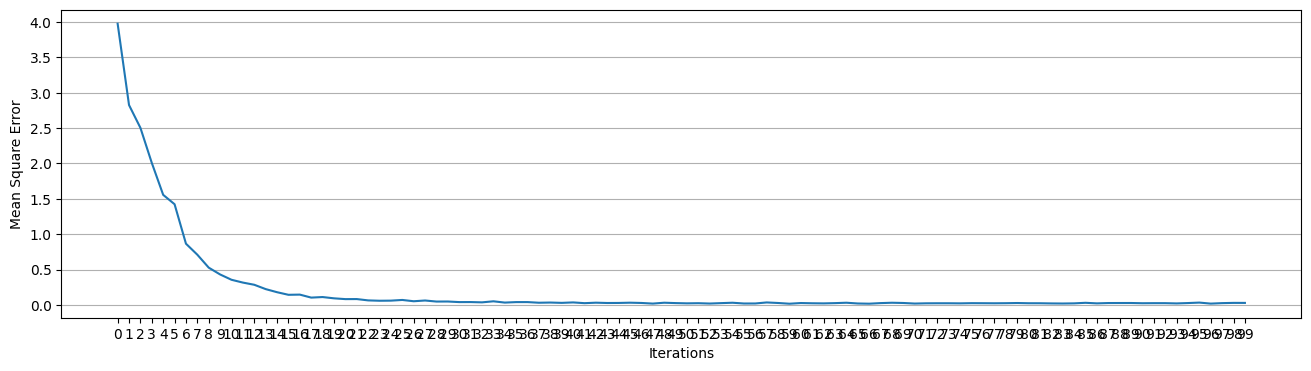

In [ ]:
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")

$\color{red}{\text{Question-5:}}$ Plot the MSE versus iterations for $\alpha=1, \gamma=0.01$ and 100 iterations of SGD

$\color{red}{\text{Answer:}}$ Put your figure here
Plotted for  $\alpha=0.03, \gamma=0.01$ and 100 iterations of SGD
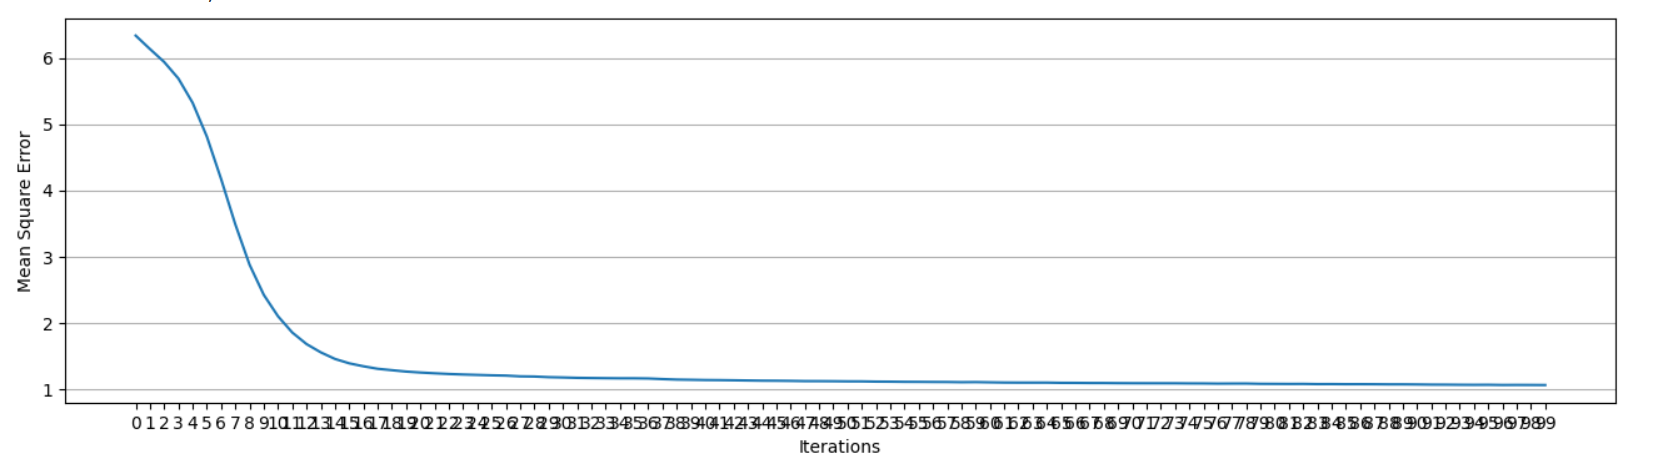

SGD Iteration: 10 ; error = 2.6373
SGD Iteration: 20 ; error = 1.6079
SGD Iteration: 30 ; error = 1.4338
SGD Iteration: 40 ; error = 1.2483
SGD Iteration: 50 ; error = 0.9899
SGD Iteration: 60 ; error = 0.8199
SGD Iteration: 70 ; error = 0.7480
SGD Iteration: 80 ; error = 0.7219
SGD Iteration: 90 ; error = 0.7119
SGD Iteration: 100 ; error = 0.7073


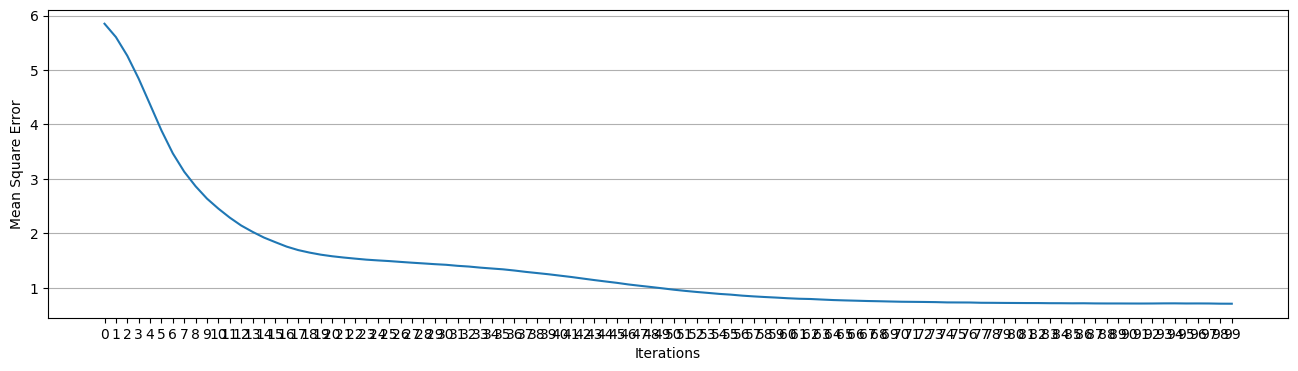

In [ ]:
# Question 5

R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

lf = LF(R, K=2, alpha=0.03, gamma=0.01, iterations=100)
training_process = lf.train()
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")

$\color{red}{\text{Question-6:}}$ Show the plot for 50 iterations, $\alpha=1, \gamma=0.01$ of SGD without bias, i.e., $b=0$

$\color{red}{\text{Answer:}}$ Paste your output and figures here or below this cell

Plotted for  $\alpha=0.03, \gamma=0.01$ and 50 iterations of SGD without bias
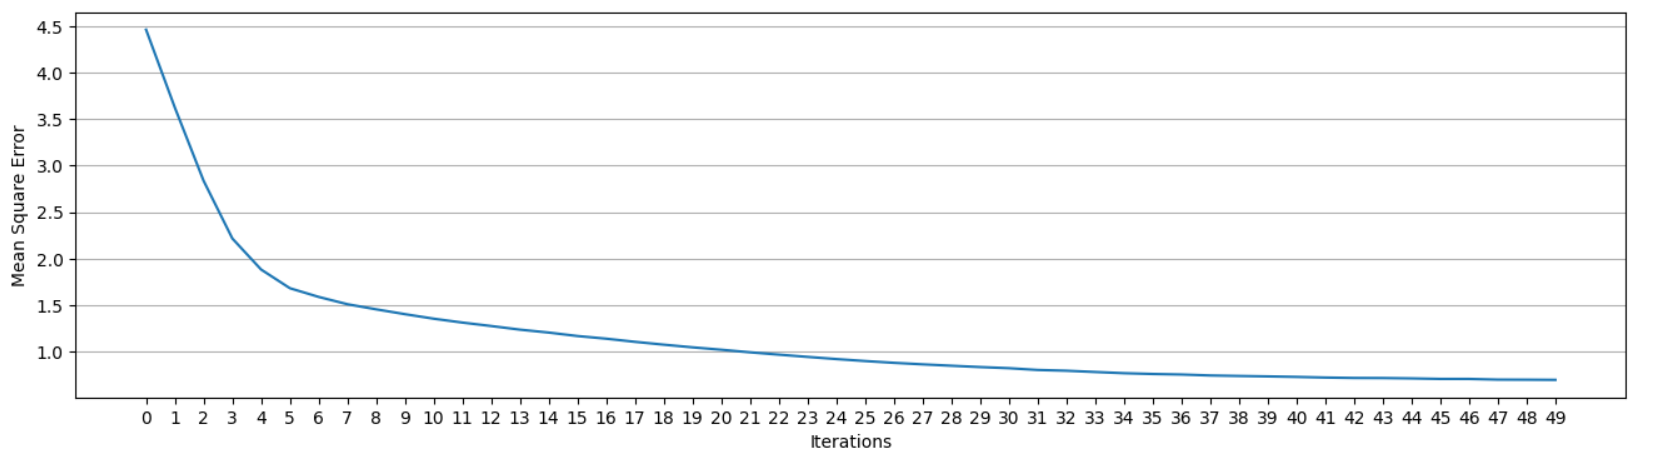

SGD Iteration: 10 ; error = 0.9601
SGD Iteration: 20 ; error = 0.4268
SGD Iteration: 30 ; error = 0.2280
SGD Iteration: 40 ; error = 0.1258
SGD Iteration: 50 ; error = 0.0724


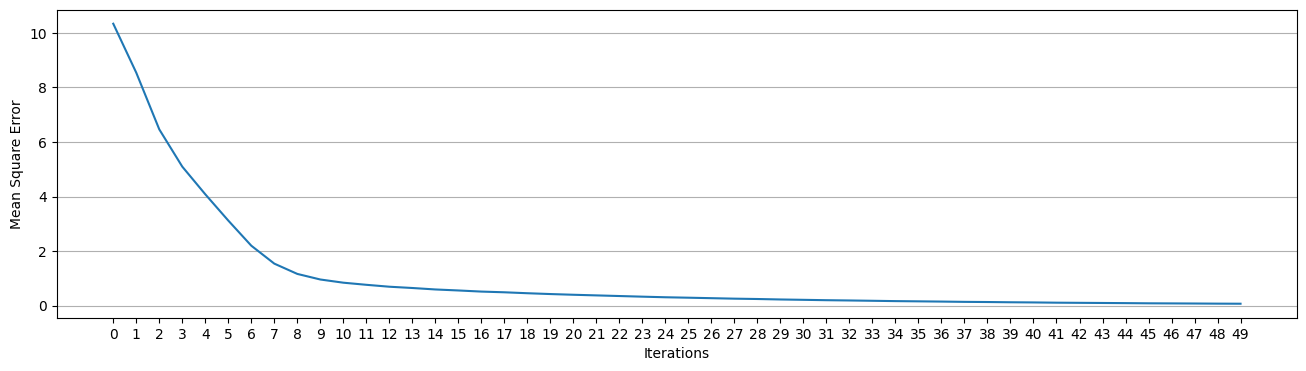

In [ ]:
# Question 6

class LF():

    def __init__(self, R, K, alpha, gamma, iterations):
        """
        Parameters:
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - gamma (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.gamma = gamma
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Compute the global bias
        # For Question-6, you may want to initialize additional bias terms here
        self.b = 0
        #self.b_i = TODO
        #self.b_u = TODO

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("SGD Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        MSE: Compute Mean Square Error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        SGD: Stochastic Graident Descent
        """
        for i, j, r in self.samples:
            # Compute prediction and error
            prediction =  lf.predict(i,j)


            e = r - prediction

            # Keep a copy of row of P. It will be needed for update
            # P_i = self.P[i, :][:]

            # Vectorized update for P[i, :] and Q[j, :]
            delta_p = 2 * e * self.Q[j, :] - self.gamma * self.P[i, :]
            delta_q = 2 * e * self.P[i, :] - self.gamma * self.Q[j, :]


            # Update user and item latent feature matrices
            self.P[i, :] +=  self.alpha * delta_p
            self.Q[j, :] +=  self.alpha * delta_q


    def gd(self):
        """
        GD: Graident Descent
        Replace self.sample below to full batch for gradient descent
        Feel free to remove everything, and implement from scratch
        """
        # for i, j, r in TODO:
        #     # Compute prediction and error
        #     prediction = TODO
        #     e = TODO

        #     # Create copy of row of P since we need to update it but use older values for update on Q
        #     P_i = self.P[i, :][:]

        #     # Update user and item latent feature matrices
        #     self.P[i, :] += TODO
        #     self.Q[j, :] += TODO

        for i in range(self.num_users):
          for j in range(self.num_items):
            if self.R[i, j] > 0:
                prediction =  lf.predict(i,j)

                # Compute prediction and error
                self.P[i, :].dot(self.Q[j, :].T)
                e += self.R[i, j] - prediction


        for i in range(self.num_users):
            P_i = self.P[i,:][:]
            self.P[i, :] += self.alpha * (2 * e * Q_j - self.gamma * P_i)



        for j in range(self.num_items):
            Q_j = self.Q[j, :][:]
            self.Q[j, :] += self.alpha * (2 * e * P_i - self.gamma * Q_j)


    def predict(self, i, j):
        """
        Prediction: Predicted the rating of user i and item j
        """
        prediction = self.b + self.P[i, :].dot(self.Q[j, :].T)

        return prediction

    def full_matrix(self):
        """
        The rating matrix using the biases P and Q
        """
        return lf.b + lf.P.dot(lf.Q.T)


R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

lf = LF(R, K=2, alpha=0.03, gamma=0.01, iterations=50)
training_process = lf.train()
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")

$\color{red}{\text{Question-7:}}$ Repeat above with bias

$\color{red}{\text{Answer:}}$ Paste your output and figures here or below this cell

7.1 Plotted for  $\alpha=0.03, \gamma=0.01$ and 100 iterations of SGD without bias

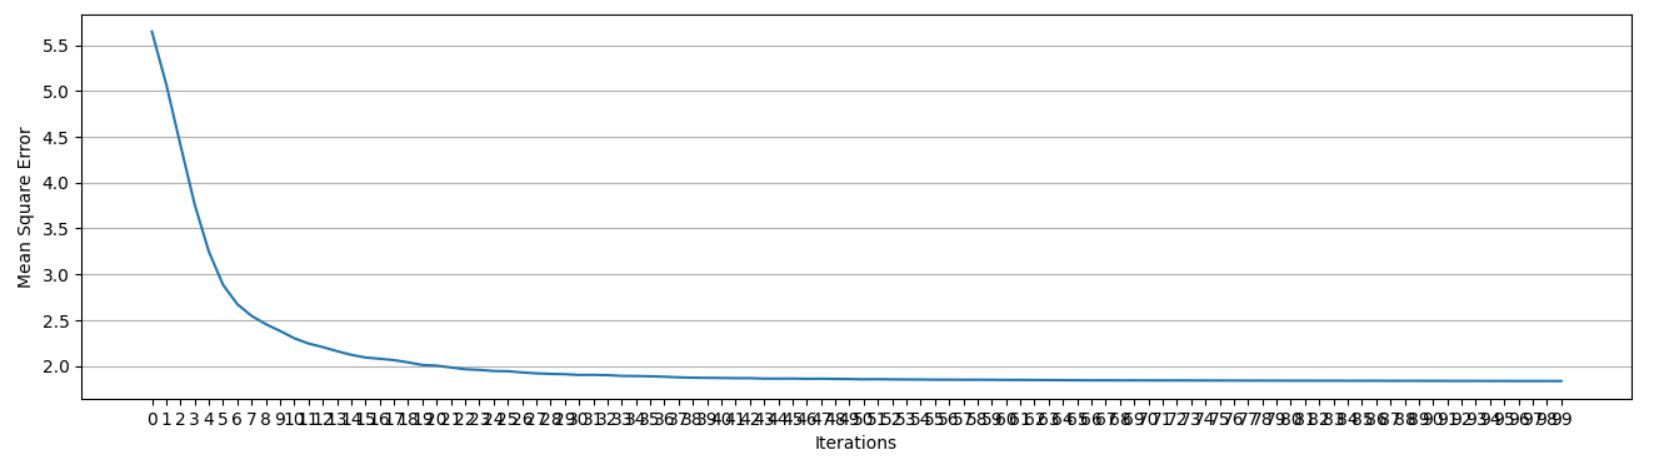


7.2 Plotted for  $\alpha=0.03, \gamma=0.01$ and 50 iterations of SGD without bias

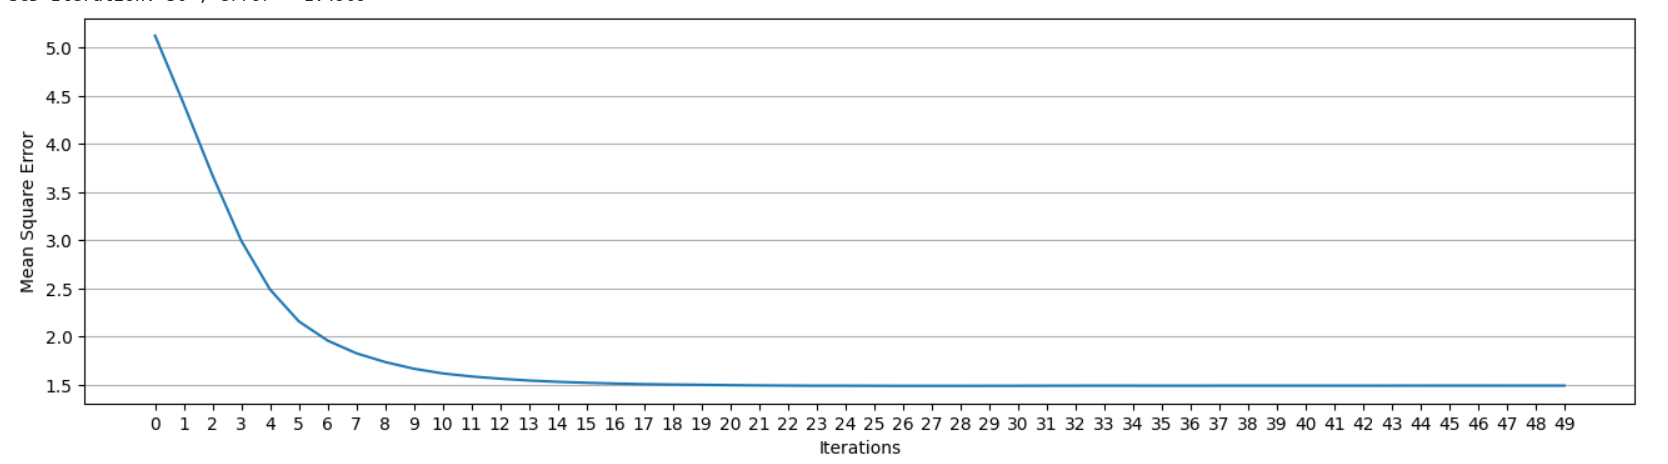


SGD Iteration: 10 ; error = 2.5531
SGD Iteration: 20 ; error = 0.6360
SGD Iteration: 30 ; error = 0.4845
SGD Iteration: 40 ; error = 0.3873
SGD Iteration: 50 ; error = 0.3182


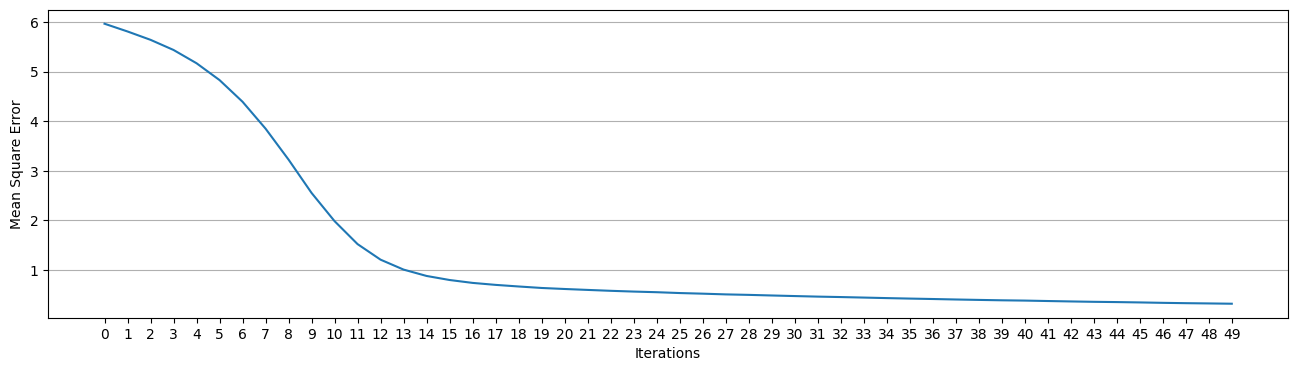

In [ ]:
# Question 7

class LF():

    def __init__(self, R, K, alpha, gamma, iterations):
        """
        Parameters:
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - gamma (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.gamma = gamma
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Compute the global bias
        # For Question-6, you may want to initialize additional bias terms here
        self.b = np.mean(self.R[np.where(self.R != 0)])
        # self.b_i = TODO
        # self.b_u = TODO
        self.b_i = np.zeros(self.num_items)
        self.b_u = np.zeros(self.num_users)

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("SGD Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        MSE: Compute Mean Square Error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        SGD: Stochastic Graident Descent
        """
        for i, j, r in self.samples:
            # Compute prediction and error
            # prediction = np.dot(self.Q[j, :].T, self.P[i, :])
            # e = r - prediction

            # with bias
            prediction = lf.predict(i,j)
            e = r - prediction

            # Keep a copy of row of P. It will be needed for update
            # P_i = self.P[i, :][:]

            # Vectorized update for P[i, :] and Q[j, :]
            delta_p = 2 * e * self.Q[j, :] - self.gamma * self.P[i, :]
            delta_q = 2 * e * self.P[i, :] - self.gamma * self.Q[j, :]


            # with bias
            self.b_i[j] += self.alpha * (e - self.gamma * self.b_i[j])
            self.b_u[i] += self.alpha * (e - self.gamma * self.b_u[i])

            # Update user and item latent feature matrices
            self.P[i, :] +=  self.alpha * delta_p
            self.Q[j, :] +=  self.alpha * delta_q


    def gd(self):
        """
        GD: Graident Descent
        Replace self.sample below to full batch for gradient descent
        Feel free to remove everything, and implement from scratch
        """
        # for i, j, r in TODO:
        #     # Compute prediction and error
        #     prediction = TODO
        #     e = TODO

        #     # Create copy of row of P since we need to update it but use older values for update on Q
        #     P_i = self.P[i, :][:]

        #     # Update user and item latent feature matrices
        #     self.P[i, :] += TODO
        #     self.Q[j, :] += TODO

        for i in range(self.num_users):
          for j in range(self.num_items):
            if self.R[i, j] > 0:
                # Compute prediction and error
                prediction = lf.predict(i,j)
                e += self.R[i, j] - prediction


        for i in range(self.num_users):
            P_i = self.P[i,:][:]
            self.P[i, :] += self.alpha * (2 * e * Q_j - self.gamma * P_i)



        for j in range(self.num_items):
            Q_j = self.Q[j, :][:]
            self.Q[j, :] += self.alpha * (2 * e * P_i - self.gamma * Q_j)


    def predict(self, i, j):
        """
        Prediction: Predicted the rating of user i and item j
        """
        prediction = self.b + self.P[i, :].dot(self.Q[j, :].T)

        return prediction

    def full_matrix(self):
        """
        The rating matrix using the biases P and Q
        """
        return lf.b + lf.P.dot(lf.Q.T)

R = np.array([[5, 3, 0, 1],
              [4, 0, 0, 1],
              [1, 1, 0, 5],
              [1, 0, 0, 4],
              [0, 1, 5, 4],])

lf = LF(R, K=2, alpha=0.03, gamma=0.01, iterations=50)
training_process = lf.train()
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")


$\color{red}{\text{Question-8:}}$ Show plots with values of regularization parameters to be 1, 0.1, 0.01, 0.001 and for 50 iterations, and $\alpha=1, \gamma=0.01$

$\color{red}{\text{Answer:}}$ Paste all your plots here or below this cell.

8.1 Plotted for $\alpha=0.03, \gamma=1$ and 50 iterations of SGD.

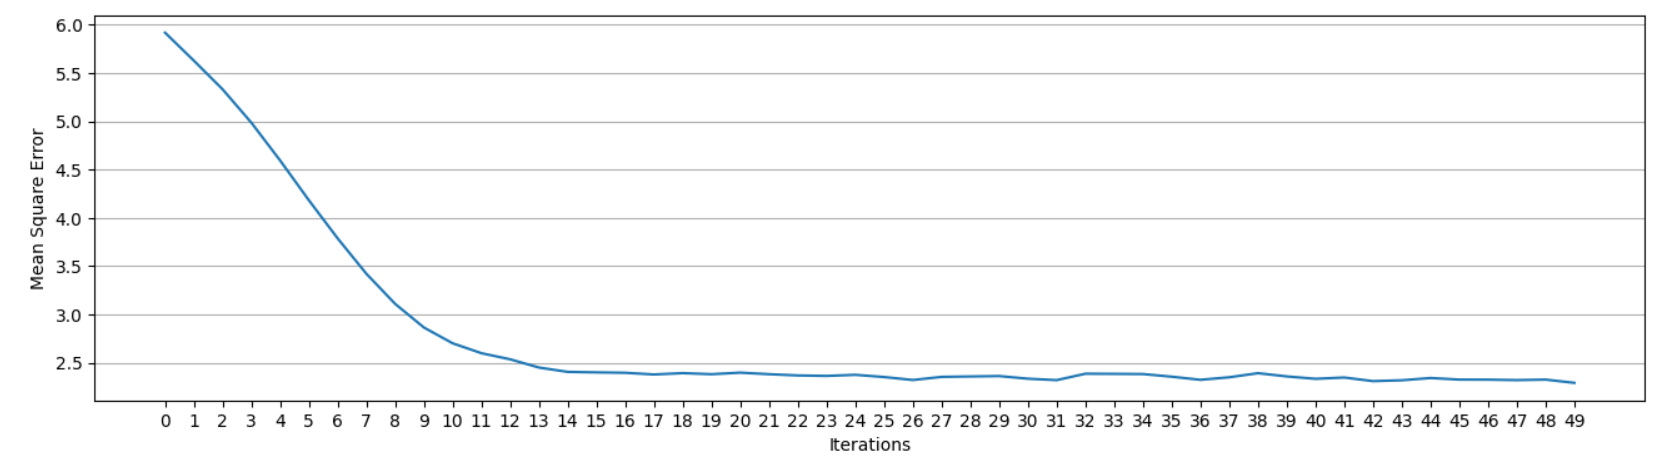

8.2 Plotted for $\alpha=0.03, \gamma=0.1$ and 50 iterations of SGD

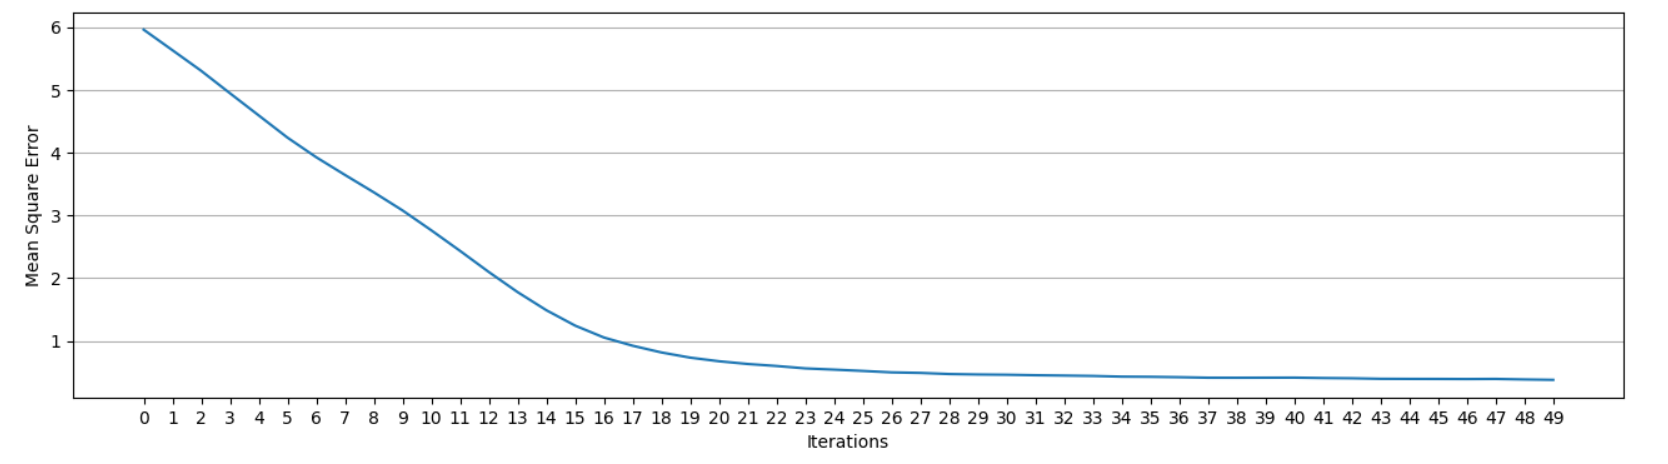

8.3 Plotted for $\alpha=0.03, \gamma=0.01$ and 50 iterations of SGD

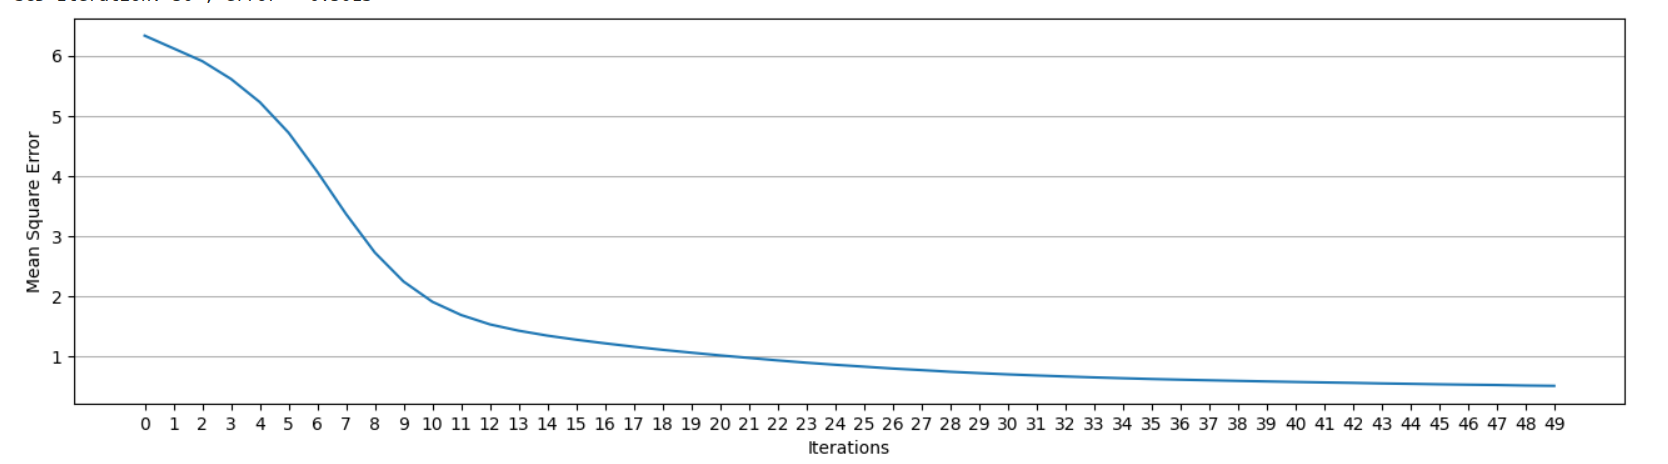

8.4 Plotted for $\alpha=0.03, \gamma=0.001$ and 50 iterations of SGD

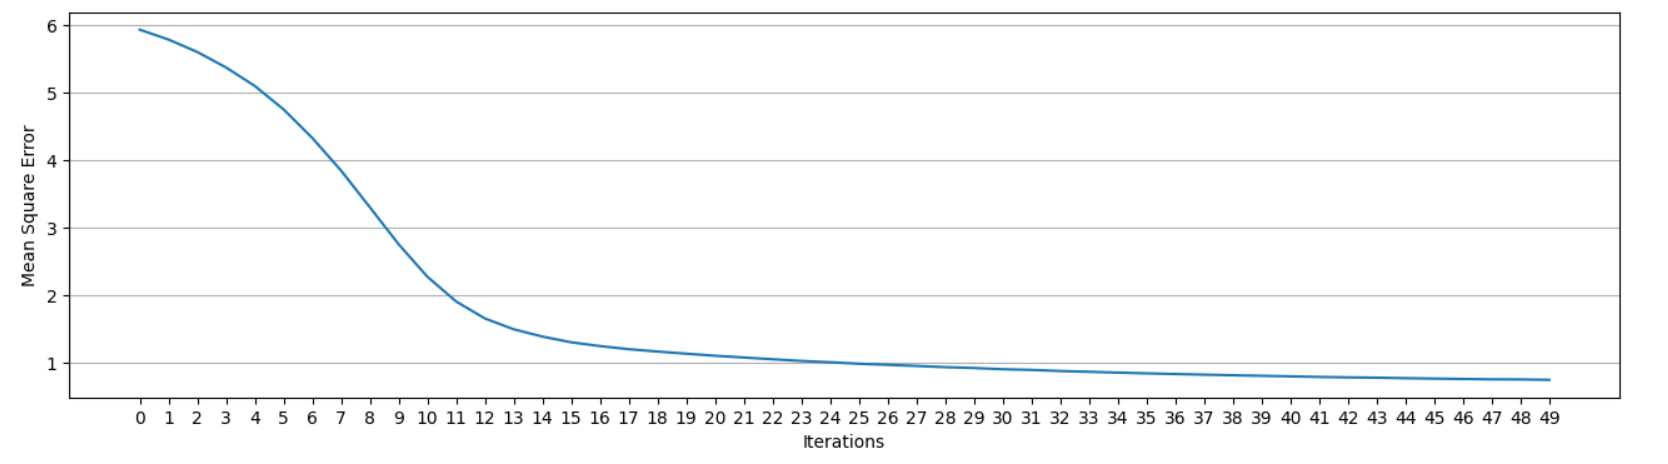



SGD Iteration: 10 ; error = 1.8076
SGD Iteration: 20 ; error = 1.0158
SGD Iteration: 30 ; error = 0.7104
SGD Iteration: 40 ; error = 0.5876
SGD Iteration: 50 ; error = 0.5373


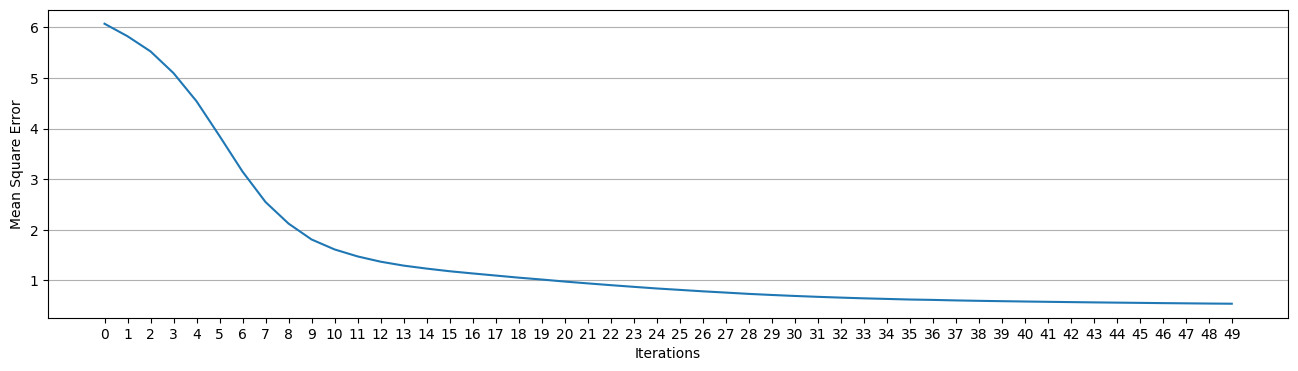

In [ ]:
# Question 8

class LF():

    def __init__(self, R, K, alpha, gamma, iterations):
        """
        Parameters:
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - gamma (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.gamma = gamma
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Compute the global bias
        # For Question-6, you may want to initialize additional bias terms here
        self.b = np.mean(self.R[np.where(self.R != 0)])
        # self.b_i = TODO
        # self.b_u = TODO
        self.b_i = np.zeros(self.num_items)
        self.b_u = np.zeros(self.num_users)

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("SGD Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        MSE: Compute Mean Square Error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        SGD: Stochastic Graident Descent
        """
        for i, j, r in self.samples:
            # Compute prediction and error
            # prediction = np.dot(self.Q[j, :].T, self.P[i, :])
            # e = r - prediction

            # with bias
            prediction = lf.predict(i,j)
            e = r - prediction

            # Keep a copy of row of P. It will be needed for update
            # P_i = self.P[i, :][:]

            # Vectorized update for P[i, :] and Q[j, :]
            delta_p = 2 * e * self.Q[j, :] - self.gamma * self.P[i, :]
            delta_q = 2 * e * self.P[i, :] - self.gamma * self.Q[j, :]


            # with bias
            self.b_i[j] += self.alpha * (e - self.gamma * self.b_i[j])
            self.b_u[i] += self.alpha * (e - self.gamma * self.b_u[i])

            # Update user and item latent feature matrices
            self.P[i, :] +=  self.alpha * delta_p
            self.Q[j, :] +=  self.alpha * delta_q


    def gd(self):
        """
        GD: Graident Descent
        Replace self.sample below to full batch for gradient descent
        Feel free to remove everything, and implement from scratch
        """
        # for i, j, r in TODO:
        #     # Compute prediction and error
        #     prediction = TODO
        #     e = TODO

        #     # Create copy of row of P since we need to update it but use older values for update on Q
        #     P_i = self.P[i, :][:]

        #     # Update user and item latent feature matrices
        #     self.P[i, :] += TODO
        #     self.Q[j, :] += TODO

        for i in range(self.num_users):
          for j in range(self.num_items):
            if self.R[i, j] > 0:
                # Compute prediction and error
                prediction = lf.predict(i,j)
                e += self.R[i, j] - prediction


        for i in range(self.num_users):
            P_i = self.P[i,:][:]
            self.P[i, :] += self.alpha * (2 * e * Q_j - self.gamma * P_i)



        for j in range(self.num_items):
            Q_j = self.Q[j, :][:]
            self.Q[j, :] += self.alpha * (2 * e * P_i - self.gamma * Q_j)


    def predict(self, i, j):
        """
        Prediction: Predicted the rating of user i and item j
        """
        prediction = self.b + self.P[i, :].dot(self.Q[j, :].T)

        return prediction

    def full_matrix(self):
        """
        The rating matrix using the biases P and Q
        """
        return lf.b + lf.P.dot(lf.Q.T)

R = np.array([[5, 3, 0, 1],
              [4, 0, 0, 1],
              [1, 1, 0, 5],
              [1, 0, 0, 4],
              [0, 1, 5, 4],])

lf = LF(R, K=2, alpha=0.03, gamma=0.001, iterations=50)
training_process = lf.train()
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")


$\color{red}{\text{Question-9:}}$ Prove that the loss function is not convex. Is the loss function differentiable?

$\color{red}{\text{Answer:}}$ Write your answer here.

The loss function for recommender systems is as follows:
$$\mathcal{L}(p_{1*}, p_{2*}, \dots p_{n*}, q_{*1}, q_{*2}, \dots, q_{*n}) = \sum_{(i,j) \in K} (r_{ij} - p_{i*}q_{*j}).$$

- In machine learning the weights and their combinations with the given data creates a model. In this case, the model is $PQ.$ Since the $k,$ is a hyperparameter, it is likely that one may choose $P$ and $Q$ to have too many columns, i.e., too many weights are used, this will lead to a large model, and hence leading to **overfitting**.


- A well known way to avoid overfitting is to do regularizations, by penalizing **large model** size. The modified loss function is as follows:
$$\mathcal{L}(\cdot) = \sum_{(i,j) \in K} (r_{ij} - p_{i*}q_{*j})^2 + \gamma/2 (\| P \|_F^2 + \| Q \|_F^2)$$
    - The term $\gamma/2(\| P \|_F^2 + \| Q \|_F^2)$ is called **regularization term**
    - The parameter $\gamma$ is called the **regularization parameter**
    - High $\gamma$ would mean that we don't want big model size; this may help prevent overfitting
- Let $e_{ij}$ denote the error corresponding to each $(ij)$ term,
$$e_{ij} = r_{ij} - \sum_{s=1}^k p_{is}q_{sj}$$
then let us define the new error term $\tilde{e}$
$$\tilde{e}_{ij} = e_{ij}^2 + \gamma/2 (\|P\|_F^2 + \| Q \|_F^2),$$
that is,
$$\tilde{e}_{ij} = (r_{ij} - \sum_{s=1}^k p_{is}q_{sj} )^2 + \gamma/2 (\|P\|_F^2 + \| Q \|_F^2)$$
- Note that $$\mathcal{L}(\cdot) = \sum_{(i,j) \in \mathcal{K}} \tilde{e}_{ij},$$
where $\mathcal{K}$ is the set of all indices for which ratings $r_{ij}$ are available.

To prove non-convexity, we need to show that there exist two points within the feasible region of the optimization problem such that the line segment connecting these two points lies below the graph of the loss function.

Consider two points $P1$ and $P2$ within the feasible region (i.e. they satisfy the constraints). Let $P1$ and $P2$ be two different sets of matrices. We can define their corresponding loss values as:

$$L_1 = \sum_{(i,j) \in K} \left( e_{ij}^2(P_1) + \frac{\gamma}{2} \left( \|P_1\|_F^2 + \|Q\|_F^2 \right) \right)$$

$$L_2 = \sum_{(i,j) \in K} \left( e_{ij}^2(P_2) + \frac{\gamma}{2} \left( \|P_2\|_F^2 + \|Q\|_F^2 \right) \right)$$

Now, consider the point $P3$ which is a convex combination of $P1$ and $P2$ :
$$P_3 = \lambda P_1 + (1-\lambda) P_2$$
where $0<Λ<1$.
The loss function corresponding to $P3$ is:
$$L_3 = \sum_{(i,j) \in K} \left( e_{ij}^2(P_3) + \frac{\gamma}{2} \left( \|P_3\|_F^2 + \|Q\|_F^2 \right) \right)
$$
Now, if we can find $P1$ and $P2$ such that $L3<min(L1,L2)$,then it implies that the loss function is non-convex. However, mathematically proving convexity maybe slightly complex.

Although the loss function for both Gradient Descent and Stochastic Gradient Descent are the, they method of updating GD and SGD is differnt. Given below explains the intuition behind the convexity of GD and SGD.

The loss function used in gradient descent for matrix factorization is not convex. This is because the optimization problem involves finding the values of both
$p_u$ and $q_i$ , which makes the problem non-convex. Convexity implies that any local minimum is also a global minimum, but in this case, there can be multiple local minima.

The loss function for stochastic gradient descent is also not convex. This is because the loss function involves the squared error term, which is a non-convex function. As a result, the overall loss function is also non-convex.

The loss function used in gradient descent for matrix factorization is differentiable. This is because the loss function is a quadratic function, and quadratic functions are differentiable everywhere. The derivatives of the loss function with respect to the parameters $p_u$ and $q_i$ can be computed, allowing for the update of these parameters during the optimization process.

Similarly, the loss function for stochastic gradient descent is also differentiable. Since it is a quadratic function, it is differentiable everywhere. The gradients of the loss function can be computed and used to update the parameters in the optimization process.

## Bonus Question

$\color{red}{\text{Question-10:}}$ In the reference paper [1] above, additional bias terms are recommended, implement it

$\color{red}{\text{Answer:}}$ Put your modified function here or below this cell.

SGD Iteration: 10 ; error = 2.3972
SGD Iteration: 20 ; error = 1.8629
SGD Iteration: 30 ; error = 1.8296
SGD Iteration: 40 ; error = 1.8302
SGD Iteration: 50 ; error = 1.8325


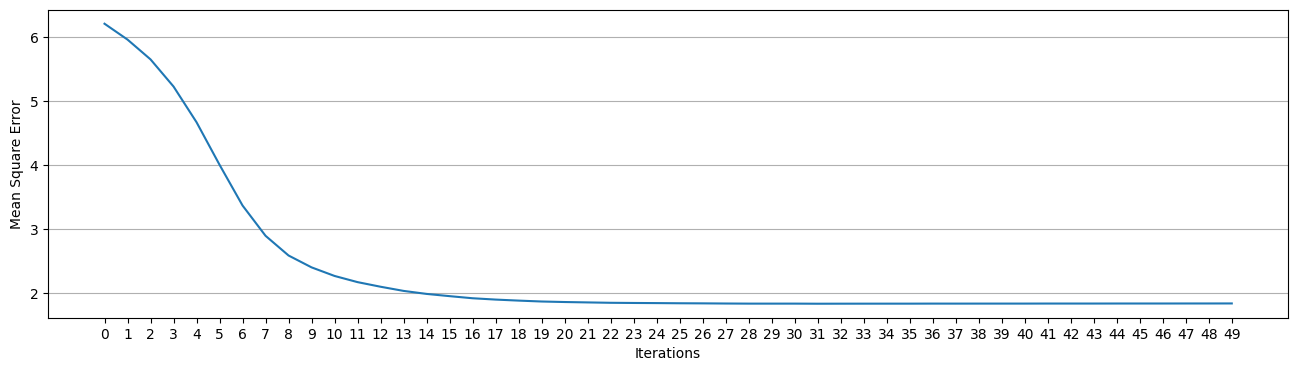

In [ ]:
# Question 10 (Bias included)

class LF():

    def __init__(self, R, K, alpha, gamma, iterations):
        """
        Parameters:
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - gamma (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.gamma = gamma
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Compute the global bias
        # For Question-6, you may want to initialize additional bias terms here
        self.b = np.mean(self.R[np.where(self.R != 0)])
        self.b_i = np.zeros(self.num_items)
        self.b_u = np.zeros(self.num_users)

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("SGD Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        MSE: Compute Mean Square Error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        SGD: Stochastic Graident Descent
        """
        for i, j, r in self.samples:
            # Compute prediction and error
            # prediction = np.dot(self.Q[j, :].T, self.P[i, :])
            # e = r - prediction

            # with bias
            prediction = lf.predict(i,j)
            e = r - prediction

            # Keep a copy of row of P. It will be needed for update
            # P_i = self.P[i, :][:]

            # Vectorized update for P[i, :] and Q[j, :]
            delta_p = 2 * e * self.Q[j, :] - self.gamma * self.P[i, :]
            delta_q = 2 * e * self.P[i, :] - self.gamma * self.Q[j, :]


            # with bias
            self.b_i[j] += self.alpha * (e - self.gamma * self.b_i[j])
            self.b_u[i] += self.alpha * (e - self.gamma * self.b_u[i])

            # Update user and item latent feature matrices
            self.P[i, :] +=  self.alpha * delta_p
            self.Q[j, :] +=  self.alpha * delta_q


    def gd(self):
        """
        GD: Graident Descent
        Replace self.sample below to full batch for gradient descent
        Feel free to remove everything, and implement from scratch
        """
        # for i, j, r in TODO:
        #     # Compute prediction and error
        #     prediction = TODO
        #     e = TODO

        #     # Create copy of row of P since we need to update it but use older values for update on Q
        #     P_i = self.P[i, :][:]

        #     # Update user and item latent feature matrices
        #     self.P[i, :] += TODO
        #     self.Q[j, :] += TODO

        for i in range(self.num_users):
          for j in range(self.num_items):
            if self.R[i, j] > 0:
                # Compute prediction and error
                prediction = lf.predict(i,j)
                e += self.R[i, j] - prediction

        for i in range(self.num_users):
            P_i = self.P[i,:][:]
            self.P[i, :] += self.alpha * (2 * e * Q_j - self.gamma * P_i)
            self.b_u[i] += self.alpha * (e - self.gamma * self.b_u[i])


        for j in range(self.num_items):
            Q_j = self.Q[j, :][:]
            self.Q[j, :] += self.alpha * (2 * e * P_i - self.gamma * Q_j)
            self.b_i[j] += self.alpha * (e - self.gamma * self.b_i[j])



    def predict(self, i, j):
        """
        Prediction: Predicted the rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)

        return prediction

    def full_matrix(self):
        """
        The rating matrix using the biases P and Q
        """
        return lf.b + lf.P.dot(lf.Q.T)

R = np.array([[5, 3, 0, 1],
              [4, 0, 0, 1],
              [1, 1, 0, 5],
              [1, 0, 0, 4],
              [0, 1, 5, 4],])

lf = LF(R, K=2, alpha=0.03, gamma=0.001, iterations=50)
training_process = lf.train()
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")


$\color{red}{\text{Question-11:}}$ Download the netflix ratings matrix, and run your algorithm.

$\color{red}{\text{Answer:}}$ Put your MSE versus iterations here.

Given below is the plot for the netflix ratings matrix (with 100,000 ratings):

SGD was calculated for $α = 0.03$ , $γ = 0.001$ and $iterations = 100$

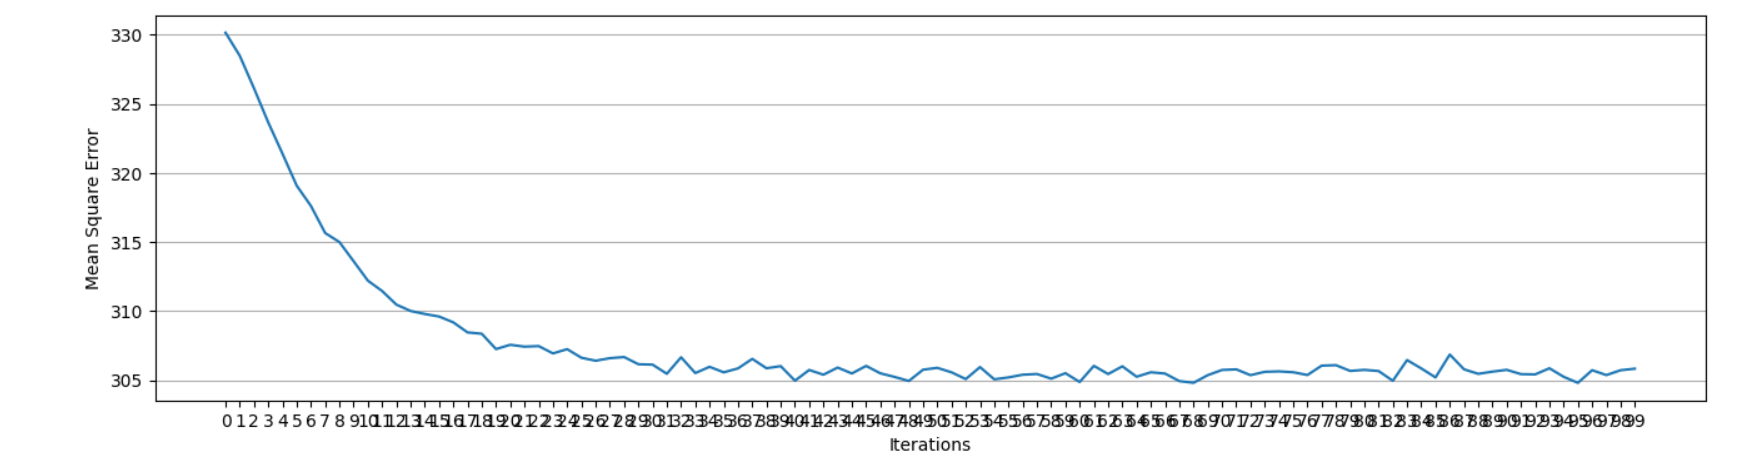

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
SGD Iteration: 10 ; error = 313.6028
SGD Iteration: 20 ; error = 307.2522
SGD Iteration: 30 ; error = 306.1578
SGD Iteration: 40 ; error = 306.0199
SGD Iteration: 50 ; error = 305.7620
SGD Iteration: 60 ; error = 305.5101
SGD Iteration: 70 ; error = 305.3681
SGD Iteration: 80 ; error = 305.6733
SGD Iteration: 90 ; error = 305.6225
SGD Iteration: 100 ; error = 305.8358


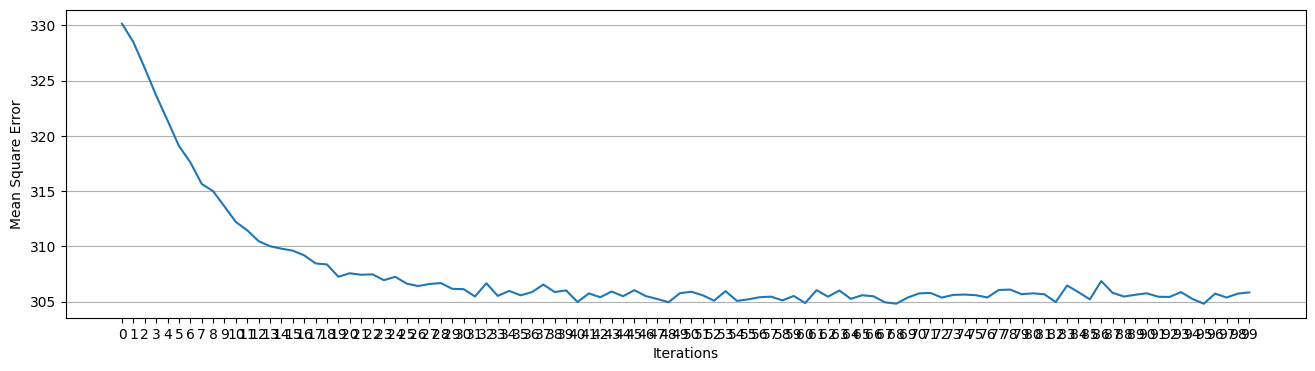

In [4]:

import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')


path = "/content/drive/My Drive/ratings.csv"
ratings_data = pd.read_csv(path)
ratings_data.head(20)

# Determine the number of unique users and unique items
num_users = ratings_data['userId'].nunique()
num_items = ratings_data['movieId'].nunique()

# Initialize the user-item rating matrix R with zeros
R = np.zeros((num_users, num_items))


# Fill in the matrix R with ratings data and dynamically resize if needed
for row in ratings_data.itertuples():
    user_idx = row.userId - 1  # Convert to 0-based index
    movie_idx = row.movieId - 1  # Convert to 0-based index

    # Check if indices are within bounds, and resize if needed
    if 0 <= user_idx < num_users and 0 <= movie_idx < num_items:
        rating = row.rating
        R[user_idx, movie_idx] = rating
    else:
        # Dynamically resize the matrix if indices are out of bounds
        new_num_users = max(num_users, user_idx + 1)
        new_num_items = max(num_items, movie_idx + 1)
        new_R = np.zeros((new_num_users, new_num_items))
        new_R[:num_users, :num_items] = R
        num_users, num_items, R = new_num_users, new_num_items, new_R


# # Fill in the matrix R with ratings data
# for row in ratings_data.itertuples():
#     user_idx = row.userId - 1  # Subtract 1 to convert to 0-based index
#     movie_idx = row.movieId - 1  # Subtract 1 to convert to 0-based index
#     rating = row.rating
#     R[user_idx, movie_idx] = rating

class LF():

    def __init__(self, R, K, alpha, gamma, iterations):
        """
        Parameters:
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - gamma (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.gamma = gamma
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Compute the global bias
        # For Question-6, you may want to initialize additional bias terms here
        self.b = np.mean(self.R[np.where(self.R != 0)])
        self.b_i = np.zeros(self.num_items)
        self.b_u = np.zeros(self.num_users)

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("SGD Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        MSE: Compute Mean Square Error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        SGD: Stochastic Graident Descent
        """
        for i, j, r in self.samples:
            # Compute prediction and error
            # prediction = np.dot(self.Q[j, :].T, self.P[i, :])
            # e = r - prediction

            # with bias
            prediction = lf.predict(i,j)
            e = r - prediction

            # Keep a copy of row of P. It will be needed for update
            # P_i = self.P[i, :][:]

            # Vectorized update for P[i, :] and Q[j, :]
            delta_p = 2 * e * self.Q[j, :] - self.gamma * self.P[i, :]
            delta_q = 2 * e * self.P[i, :] - self.gamma * self.Q[j, :]


            # with bias
            self.b_i[j] += self.alpha * (e - self.gamma * self.b_i[j])
            self.b_u[i] += self.alpha * (e - self.gamma * self.b_u[i])

            # Update user and item latent feature matrices
            self.P[i, :] +=  self.alpha * delta_p
            self.Q[j, :] +=  self.alpha * delta_q


    def gd(self):
        """
        GD: Graident Descent
        Replace self.sample below to full batch for gradient descent
        Feel free to remove everything, and implement from scratch
        """
        # for i, j, r in TODO:
        #     # Compute prediction and error
        #     prediction = TODO
        #     e = TODO

        #     # Create copy of row of P since we need to update it but use older values for update on Q
        #     P_i = self.P[i, :][:]

        #     # Update user and item latent feature matrices
        #     self.P[i, :] += TODO
        #     self.Q[j, :] += TODO

        for i in range(self.num_users):
          for j in range(self.num_items):
            if self.R[i, j] > 0:
                # Compute prediction and error
                prediction = lf.predict(i,j)
                e += self.R[i, j] - prediction

        for i in range(self.num_users):
            P_i = self.P[i,:][:]
            self.P[i, :] += self.alpha * (2 * e * Q_j - self.gamma * P_i)
            self.b_u[i] += self.alpha * (e - self.gamma * self.b_u[i])


        for j in range(self.num_items):
            Q_j = self.Q[j, :][:]
            self.Q[j, :] += self.alpha * (2 * e * P_i - self.gamma * Q_j)
            self.b_i[j] += self.alpha * (e - self.gamma * self.b_i[j])



    def predict(self, i, j):
        """
        Prediction: Predicted the rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)

        return prediction

    def full_matrix(self):
        """
        The rating matrix using the biases P and Q
        """
        return lf.b + lf.P.dot(lf.Q.T)

# R = np.array([[5, 3, 0, 1],
#               [4, 0, 0, 1],
#               [1, 1, 0, 5],
#               [1, 0, 0, 4],
#               [0, 1, 5, 4],])

lf = LF(R, K=2, alpha=0.03, gamma=0.001, iterations=100)
training_process = lf.train()
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")



## Thats All Folks! Further Readings or Infomation
https://www.coursera.org/learn/networks-illustrated/lecture/8GPZT/netflix-timeline

# Keep Recommending!